In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
shape = X_train.shape[1]

In [3]:
from tensorflow.keras import layers, losses, regularizers, optimizers
import tensorflow as tf

model = tf.keras.Sequential([
    layers.Dense(shape, activation="swish", use_bias=False),
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),  
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(), # 因子标准化
    layers.Dense(256, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(0.002)),
])

model.compile(optimizer=optimizers.Adam(0.0003), loss="mse", metrics=["mae", "mape"])

history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=256
)
model.save('dnn')

Epoch 1/20
2353/2353 [==============================] - 91s 38ms/step - loss: 2.5619 - mae: 0.7232 - mape: 1558.5968 - val_loss: 1.3499 - val_mae: 0.7203 - val_mape: 2692.2065
Epoch 2/20
2353/2353 [==============================] - 89s 38ms/step - loss: 1.0509 - mae: 0.7044 - mape: 649.5652 - val_loss: 0.9240 - val_mae: 0.7060 - val_mape: 688.3252
Epoch 3/20
2353/2353 [==============================] - 87s 37ms/step - loss: 0.8937 - mae: 0.7036 - mape: 435.8046 - val_loss: 0.8958 - val_mae: 0.7070 - val_mape: 677.3823
Epoch 4/20
2353/2353 [==============================] - 91s 39ms/step - loss: 0.8863 - mae: 0.7033 - mape: 541.8781 - val_loss: 0.8948 - val_mae: 0.7068 - val_mape: 639.6970
Epoch 5/20
2353/2353 [==============================] - 89s 38ms/step - loss: 0.8861 - mae: 0.7032 - mape: 688.9493 - val_loss: 0.8959 - val_mae: 0.7081 - val_mape: 835.7195
Epoch 6/20
2353/2353 [==============================] - 88s 37ms/step - loss: 0.8858 - mae: 0.7032 - mape: 600.3174 - val_loss: 

INFO:tensorflow:Assets written to: dnn\assets


INFO:tensorflow:Assets written to: dnn\assets


In [4]:
import pandas as pd
import scutquant.scutquant as q

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

8773/8773 [==============================] - 28s 3ms/step


,predict
count,280721.000000
mean,-0.000480
std,0.002580
min,-0.126607
25%,-0.001267
50%,-0.000169
75%,0.000689
max,0.036378


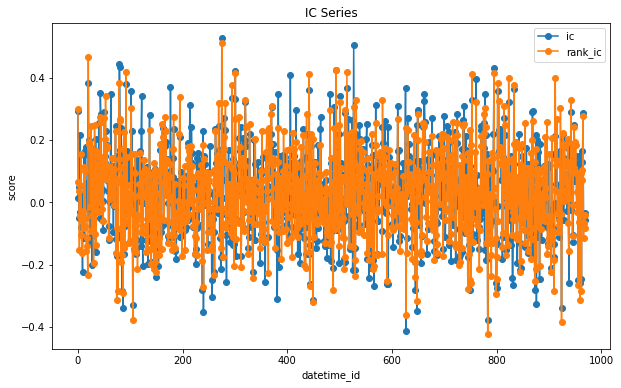

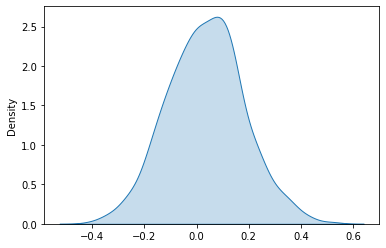

ic= 0.03411716381884229 icir= 0.23163100201976458 rank_ic= 0.02973408417031859 rank_icir= 0.20893643646849322


0.0351450712997534

In [5]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5285459936417773


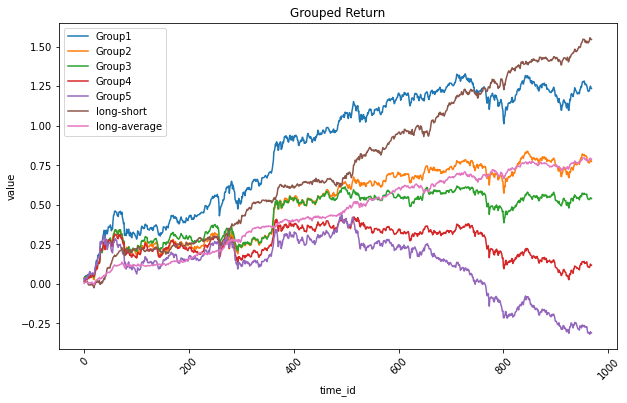

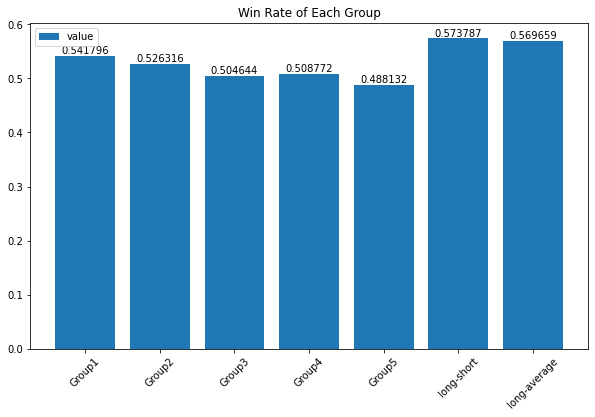

In [6]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='close', volume='vol')
report.group_return_ana(pred, y_test)

In [7]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票. 自动平仓
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.21753289187125824
Annualized Volatility: 0.7957176523430447
Annualized Return(Benchmark): 0.08018445873901148
Annualized Volatility(Benchmark): 0.3411866172573901 

Cumulative Rate of Return: 1.1315408199946502
Cumulative Rate of Return(Benchmark): 0.3452639230000001
Cumulative Excess Rate of Return: 0.7862768969946501 

Max Drawdown: -0.5439272096267855
Max Drawdown(Benchmark): -0.541086994 

Sharpe Ratio: 1.7952856783243045
Sortino Ratio: 3.629934556073428
Information Ratio: 0.7584699529080837 

Beta: 1.8548155445211234
Alpha: -0.05193530917200795
Epsilon: 0.245991497130276
Profitable Days(%): 0.7925696594427245


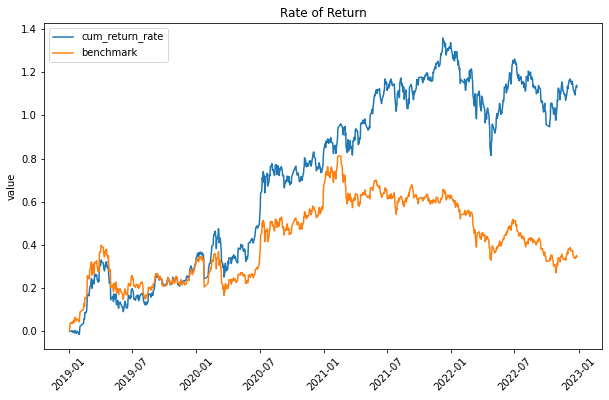

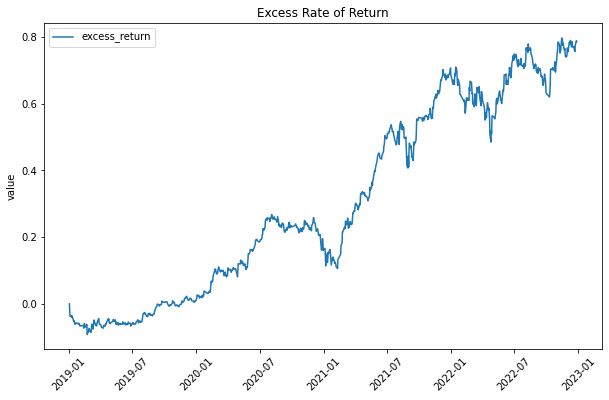

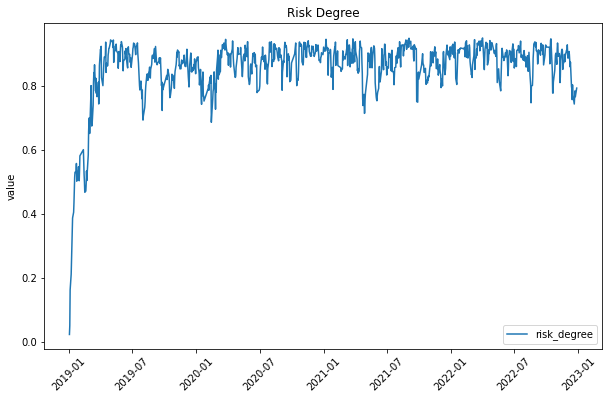

In [8]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节